In [35]:
# Install necessary libraries
!pip install pandas numpy scikit-learn

# Import all the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import joblib

print("Libraries imported.")

Libraries imported.


In [36]:
# --- IMPORTANT ---
file_name = "crop_yield.csv"
# -----------------

try:
    df = pd.read_csv("crop_yield.csv")
    print("Dataset loaded successfully!")
    print(df.head())
except FileNotFoundError:
    print(f"--- ERROR ---")
    print(f"File '{file_name}' not found. Please upload it to your Colab session.")
except Exception as e:
    print(f"An error occurred: {e}")

Dataset loaded successfully!
  Region Soil_Type     Crop  Rainfall_mm  Temperature_Celsius  \
0   West     Sandy   Cotton   897.077239            27.676966   
1  South      Clay     Rice   992.673282            18.026142   
2  North      Loam   Barley   147.998025            29.794042   
3  North     Sandy  Soybean   986.866331            16.644190   
4  South      Silt    Wheat   730.379174            31.620687   

   Fertilizer_Used  Irrigation_Used Weather_Condition  Days_to_Harvest  \
0            False             True            Cloudy              122   
1             True             True             Rainy              140   
2            False            False             Sunny              106   
3            False             True             Rainy              146   
4             True             True            Cloudy              110   

   Yield_tons_per_hectare  
0                6.555816  
1                8.527341  
2                1.127443  
3                6.5175

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Region                  1000000 non-null  object 
 1   Soil_Type               1000000 non-null  object 
 2   Crop                    1000000 non-null  object 
 3   Rainfall_mm             1000000 non-null  float64
 4   Temperature_Celsius     1000000 non-null  float64
 5   Fertilizer_Used         1000000 non-null  bool   
 6   Irrigation_Used         1000000 non-null  bool   
 7   Weather_Condition       1000000 non-null  object 
 8   Days_to_Harvest         1000000 non-null  int64  
 9   Yield_tons_per_hectare  1000000 non-null  float64
dtypes: bool(2), float64(3), int64(1), object(4)
memory usage: 62.9+ MB

--- Descriptive Statistics ---
          Rainfall_mm  Temperature_Celsius  Days_to_Harvest  \
count  1000000.000000       1000000.0000

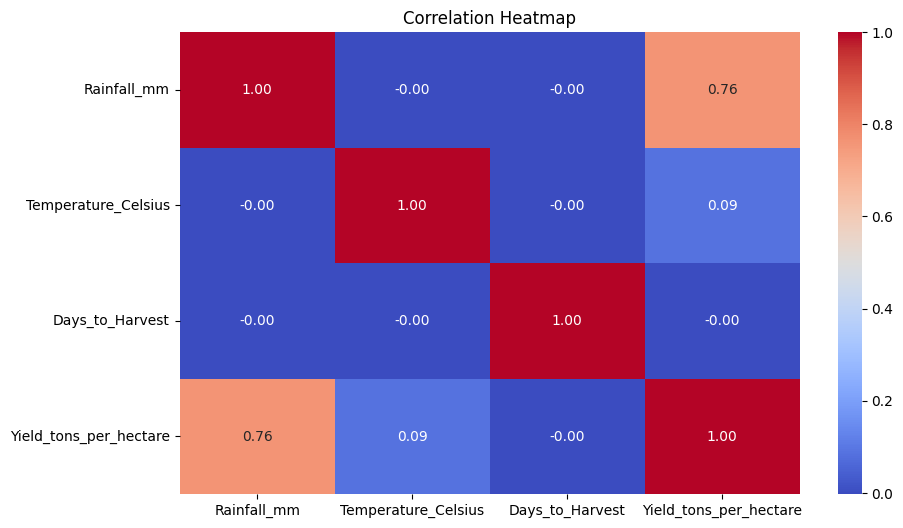

/tmp/ipython-input-1064821022.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


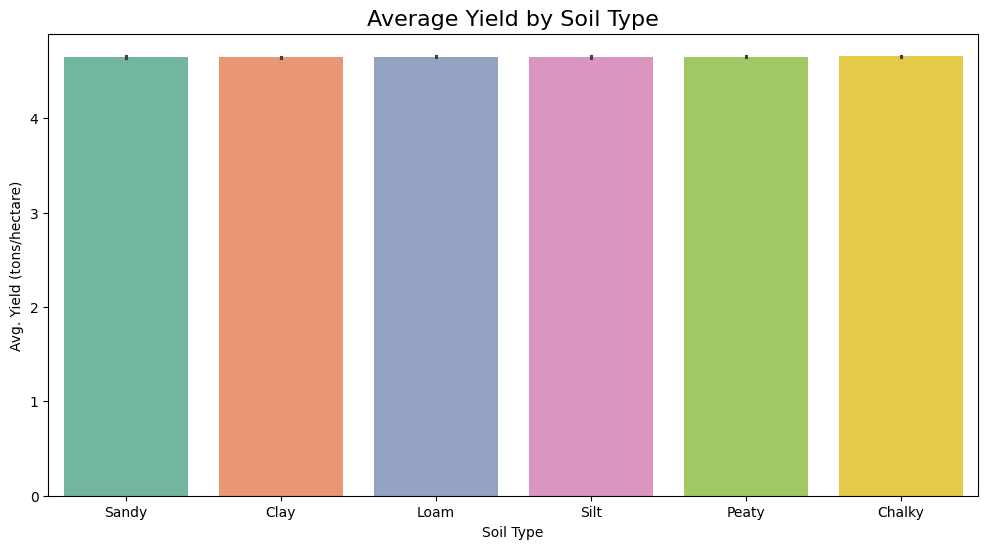

In [37]:
# 1. Basic Information
print("--- Dataset Info ---")
df.info()

# 2. Descriptive Statistics for numerical columns
print("\n--- Descriptive Statistics ---")
print(df.describe())

# 3. Value Counts for key categorical columns
print("\n--- Soil Type Distribution ---")
print(df['Soil_Type'].value_counts())

print("\n--- Crop Distribution ---")
print(df['Crop'].value_counts().head(5)) # Show top 5 crops

# 4. Correlation Heatmap for numerical features
plt.figure(figsize=(10, 6))
# Select only columns that are numeric for the correlation matrix
numeric_cols = df.select_dtypes(include=np.number).columns
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# 5. Relationship between Soil Type and Yield
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df,
    x='Soil_Type',
    y='Yield_tons_per_hectare',
    palette='Set2'
)
plt.title('Average Yield by Soil Type', fontsize=16)
plt.ylabel('Avg. Yield (tons/hectare)')
plt.xlabel('Soil Type')
plt.show()

In [38]:
print("Starting feature engineering...")

# Make a copy to work on
df_processed = df.copy()

# 1. Drop any rows with missing data
df_processed = df_processed.dropna()

# 2. Convert boolean columns to integers (1 or 0)
df_processed['Fertilizer_Used'] = df_processed['Fertilizer_Used'].astype(int)
df_processed['Irrigation_Used'] = df_processed['Irrigation_Used'].astype(int)

# 3. Create the new engineered features
df_processed['Temp_sq'] = df_processed['Temperature_Celsius']**2
df_processed['Rainfall_sq'] = df_processed['Rainfall_mm']**2
df_processed['Rainfall_x_Temp'] = df_processed['Rainfall_mm'] * df_processed['Temperature_Celsius']
df_processed['Fert_x_Irrig'] = df_processed['Fertilizer_Used'] * df_processed['Irrigation_Used']

print("Engineered features created:")
print(df_processed[['Temperature_Celsius', 'Temp_sq', 'Fertilizer_Used', 'Irrigation_Used', 'Fert_x_Irrig']].head())

Starting feature engineering...
Engineered features created:
   Temperature_Celsius     Temp_sq  Fertilizer_Used  Irrigation_Used  \
0            27.676966  766.014468                0                1   
1            18.026142  324.941805                1                1   
2            29.794042  887.684963                0                0   
3            16.644190  277.029067                0                1   
4            31.620687  999.867870                1                1   

   Fert_x_Irrig  
0             0  
1             1  
2             0  
3             0  
4             1  


In [39]:
# Define the target variable
target = 'Yield_tons_per_hectare'

# y is the target
y = df_processed[target]

# X is everything else EXCEPT the target
X = df_processed.drop(target, axis=1)

print("Features (X) and Target (y) have been defined.")
print(f"Total features in X: {X.shape[1]}")

Features (X) and Target (y) have been defined.
Total features in X: 13


In [40]:
# 1. Identify categorical and numerical features from our new X
categorical_features = X.select_dtypes(include=['object', 'category']).columns
numerical_features = X.select_dtypes(include=['number', 'bool']).columns

print(f"Categorical features: {list(categorical_features)}")
print(f"Numerical features: {list(numerical_features)}")

# 2. Create a transformer for numerical features (scale them)
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# 3. Create a transformer for categorical features (one-hot encode them)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 4. Combine these transformers into a single "preprocessor"
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("\nPreprocessor created successfully!")

Categorical features: ['Region', 'Soil_Type', 'Crop', 'Weather_Condition']
Numerical features: ['Rainfall_mm', 'Temperature_Celsius', 'Fertilizer_Used', 'Irrigation_Used', 'Days_to_Harvest', 'Temp_sq', 'Rainfall_sq', 'Rainfall_x_Temp', 'Fert_x_Irrig']

Preprocessor created successfully!


In [41]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set has {len(X_train)} samples.")
print(f"Testing set has {len(X_test)} samples.")

Training set has 800000 samples.
Testing set has 200000 samples.


In [42]:
# In your Colab training cell (e.g., Cell 7)
# Use this INSTEAD of your old RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

# We are TUNING it to be smaller
# max_depth=10 will make it *dramatically* smaller and faster
# n_estimators=100 is plenty
model_to_train = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,       # <-- This is the key to reducing size
    random_state=42,
    n_jobs=-1
)

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model_to_train)
])

print("Training a SMALLER Random Forest model...")
model_pipeline.fit(X_train, y_train)

Training a SMALLER Random Forest model...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Rainfall_mm', 'Temperature_Celsius', 'Fertilizer_Used',
       'Irrigation_Used', 'Days_to_Harvest', 'Temp_sq', 'Rainfall_sq',
       'Rainfall_x_Temp', 'Fert_x_Irrig'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Region', 'Soil_Type', 'Crop', 'Weather_Condition'], dtype='object'))])),
                ('regressor',
                 RandomForestRegressor(max_depth=10, n_jobs=-1,
                                       random_state=42))])

In [43]:
# --- Evaluate the Model ---
print("Evaluating model on the test set...")
score = model_pipeline.score(X_test, y_test)

print(f"\nModel Test R-squared score: {score * 100:.2f}%")

Evaluating model on the test set...

Model Test R-squared score: 91.27%


In [44]:
# Calculate R-squared for both training and testing sets
y_train_pred = model_pipeline.predict(X_train)
y_test_pred = model_pipeline.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Store the results in a dictionary
model_results = {
    'RandomForestRegressor': {
        'Train R²': train_r2 * 100,
        'Test R²': test_r2 * 100
    }
}

print("Model results calculated and stored in 'model_results'.")
print(model_results)

Model results calculated and stored in 'model_results'.
{'RandomForestRegressor': {'Train R²': 91.41705500383854, 'Test R²': 91.27045838418695}}


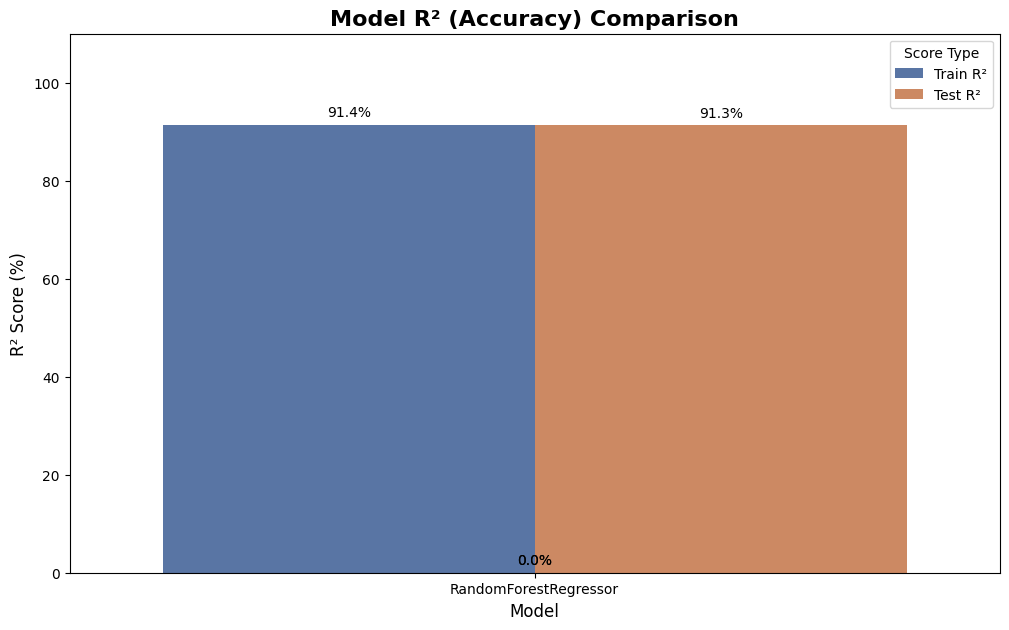

In [45]:
# Convert the results dictionary into a pandas DataFrame for easy plotting
results_df = pd.DataFrame(model_results).T.reset_index()
results_df = results_df.rename(columns={'index': 'Model'})

# "Melt" the DataFrame to a "long" format, which is what seaborn likes
plot_df = results_df.melt(id_vars='Model', var_name='Metric', value_name='R² Score (%)')

# Create the bar plot
plt.figure(figsize=(12, 7))
ax = sns.barplot(
    data=plot_df,
    x='Model',
    y='R² Score (%)',
    hue='Metric',
    palette=['#4C72B0', '#DD8452'] # Blue for Train, Orange for Test
)

# Add titles and labels
plt.title('Model R² (Accuracy) Comparison', fontsize=16, fontweight='bold')
plt.ylabel('R² Score (%)', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.ylim(0, 110) # Set Y-axis from 0% to 110%
plt.legend(title='Score Type')

# Add the percentage labels on top of each bar
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.1f}%",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 9),
        textcoords='offset points',
        fontweight='medium'
    )

plt.show()

In [46]:
# Define the model filename
model_filename = 'crop_model_pipeline.joblib'

# Save the model pipeline
joblib.dump(model_pipeline, model_filename)

print(f"Model pipeline saved as: {model_filename}")

Model pipeline saved as: crop_model_pipeline.joblib


In [47]:
# Define the app data filename
app_data_filename = 'app_data_v2.joblib'

# Get the unique values from the original 'df' for the dropdowns
app_data = {
    'regions': sorted(df['Region'].unique()),
    'soil_types': sorted(df['Soil_Type'].unique()),
    'crops': sorted(df['Crop'].unique()),
    'weather_conditions': sorted(df['Weather_Condition'].unique()),
}

# Save the data
joblib.dump(app_data, app_data_filename)

print(f"App data (for dropdowns) saved as: {app_data_filename}")

App data (for dropdowns) saved as: app_data_v2.joblib
